In [ ]:
### Trend and information flow of Russia propaganda
# https://www.kaggle.com/code/alifiyabatterywala/ukraine-vs-russian-topic-modeling/notebook


In [1]:
import pandas as pd 
import numpy as np
import os
import csv
import warnings
warnings.simplefilter(action='ignore')
import gc
from pathlib import Path
import math
import glob

In [6]:
# create a filelist for reading .gzip datasets 

# method 1
data_location = os.path.join('kaggle', '*.gzip')

filenames = glob.glob(data_location)
print(filenames)

['kaggle/UkraineCombinedTweetsDeduped_MAR05.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR04.csv.gzip', 'kaggle/0401_UkraineCombinedTweetsDeduped.csv.gzip', 'kaggle/0402_UkraineCombinedTweetsDeduped.csv.gzip', 'kaggle/0403_UkraineCombinedTweetsDeduped.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_FEB27.csv.gzip', 'kaggle/0405_UkraineCombinedTweetsDeduped.csv.gzip', 'kaggle/0404_UkraineCombinedTweetsDeduped.csv.gzip', 'kaggle/0407_UkraineCombinedTweetsDeduped.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR31.csv.gzip', 'kaggle/0406_UkraineCombinedTweetsDeduped.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR12.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR13.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR18.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR19.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR26.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR15.csv.gzip', 'kaggle/UkraineCombinedTweetsDeduped_MAR14.csv.gzip', 'kaggle/UkraineCombinedTweetsDedup

In [7]:
# search for tweets with keywords 

columns = ["userid","username","location","language","tweetid","tweetcreatedts","retweetcount", "hashtags", "text", "usercreatedts", "following", "followers","totaltweets"]

filenames.sort()
dataframe_collection = []
# create empty dataframes for subtopics
dfnames = ['df_smo', 'df_R_smo','df_unazi','df_nazi']
for x in dfnames: exec(x + ' = pd.DataFrame()')

for csvfile in filenames:
    df = pd.read_csv(csvfile, compression='gzip', index_col=0,encoding='utf-8', quoting=csv.QUOTE_ALL)
    df = df[columns]
    # key word selection
    df_smo = pd.concat([df_smo, df[df['text'].str.contains('special military operation')]])
    df_R_smo = pd.concat([df_R_smo, df[df['text'].str.contains('специальная военная операция')]])
    df_unazi = pd.concat([df_unazi, df[df['text'].str.contains('cleanse of Nazis' or 'Ukrainian Nazis')]])
    df_nazi = pd.concat([df_nazi, df[df['text'].str.contains('Neo-Nazis' or 'fascists')] ])
    
gc.collect()



599

In [8]:
# combine datasets from different days
print(len(df_smo),len(df_R_smo), len(df_unazi), len(df_nazi))

11918 4 0 5419


## "Special military operation"

In [9]:
# a function to split and clean "hashtags" column

def SplitTags(hashtags):
    TAGS=[]
    if hashtags != '[]':
        tags_split = hashtags[1:-1].split('{')
        for t in tags_split:
            if t!='':
                TAGS+=[t.split(': ')[1].split(',')[0][1:-1]]
        return TAGS
    else: return "NA"

def LowerTags(hashtags):
    TAGS=[]
    if hashtags != '[]':
        tags_split = hashtags[1:-1].split('{')
        for t in tags_split:
            if t!='':
                TAGS+=[t.split(': ')[1].split(',')[0][1:-1]]
    lower_TAGS = (map(lambda x: x.lower(), TAGS))
    TAGS = list(lower_TAGS)
    if len(TAGS)>0:
        return TAGS
    else: return "NA"

            
df_smo['tags_splitted'] = df_smo['hashtags'].apply(SplitTags)
df_smo['tags_lower'] = df_smo['hashtags'].apply(LowerTags)

In [10]:
# import the manually labelled new hashtag list
with open("labelled.txt", 'r', encoding='UTF-8') as infile:
    lines = infile.readlines()

    labelled_tags = pd.DataFrame(columns=lines[0].split())
    
    for line in lines[1:]:
        df_length = len(labelled_tags)
        labelled_tags.loc[df_length] = line.split()[1:]
        
labelled_tags["pro_u"] = labelled_tags["pro_u"].apply(lambda x: eval(x))
labelled_tags["pro_r"] = labelled_tags["pro_r"].apply(lambda x: eval(x))
labelled_tags["neutral"] = labelled_tags["neutral"].apply(lambda x: eval(x))
labelled_tags.head()

pro_russian_tags = labelled_tags["tag"][labelled_tags["pro_r"]==True]
pro_ukrainian_tags = labelled_tags["tag"][labelled_tags["pro_u"]==True]
neural_tags = labelled_tags["tag"][labelled_tags["neutral"]==True]


In [11]:
# change all tags to lowercase before matching to avoid spelling difference
lower_R = (map(lambda x: x.lower(), pro_russian_tags))
pro_russian_tags = list(lower_R)

lower_U = (map(lambda x: x.lower(), pro_ukrainian_tags))
pro_ukrainian_tags = list(lower_U)

lower_N = (map(lambda x: x.lower(), neural_tags))
neural_tags = list(lower_N)

In [12]:
# Create lambda functions to mark political orientation if related hashtags were found 

# lambda functions marking political orientation if related hashtags were found 
pro_R_check = lambda taglist: bool(set(taglist) & set(pro_russian_tags)) # return true if overlap of two sets not empty
pro_U_check = lambda taglist: bool(set(taglist) & set(pro_ukrainian_tags)) 
N_check = lambda taglist: bool(set(taglist) & set(neural_tags)) 


df_smo['pro_Russian'] = df_smo['tags_lower'].apply(pro_R_check)
df_smo['pro_Ukraine'] = df_smo['tags_lower'].apply(pro_U_check)
df_smo['Neutral'] = df_smo['tags_lower'].apply(N_check)

In [13]:
# Determine a tweet's stance by it's hashtags: pro-russian / pro-ukrainian / both/ Neutral/ unknown
df_smo['NodeType'] = np.where(
     df_smo['pro_Russian'] & df_smo['pro_Ukraine'], 'Both',
     np.where(
         df_smo['pro_Russian'],  'pro_Russian',
     np.where(
        df_smo['pro_Ukraine'], 'pro_Ukraine', 
     np.where(
         df_smo['Neutral'],'Neutral','Unknown'
     ))))

df_smo.head(2)

# export dataframe 
# df_smo.to_csv("20220508keywords_smo.csv",sep = ",", header = True, encoding = "UTF-8",index=False)

,userid,username,location,language,tweetid,tweetcreatedts,retweetcount,hashtags,text,usercreatedts,following,followers,totaltweets,tags_splitted,tags_lower,pro_Russian,pro_Ukraine,Neutral,NodeType
373,1123400778,WizardBear1,"Hawaii, USA",en,1509682342587109379,2022-04-01 00:01:33.000000,151,[],The sounds of war in Ukraine. \n\nPutin calls ...,2013-01-26 23:10:16.000000,1289,1019,78199,NA,NA,False,False,False,Unknown
907,1725818820,MaureenStaehle,"Nova Scotia, Canada",en,1509683012065275910,2022-04-01 00:04:13.000000,151,[],The sounds of war in Ukraine. \n\nPutin calls ...,2013-09-03 15:32:02.000000,5005,1313,39329,NA,NA,False,False,False,Unknown


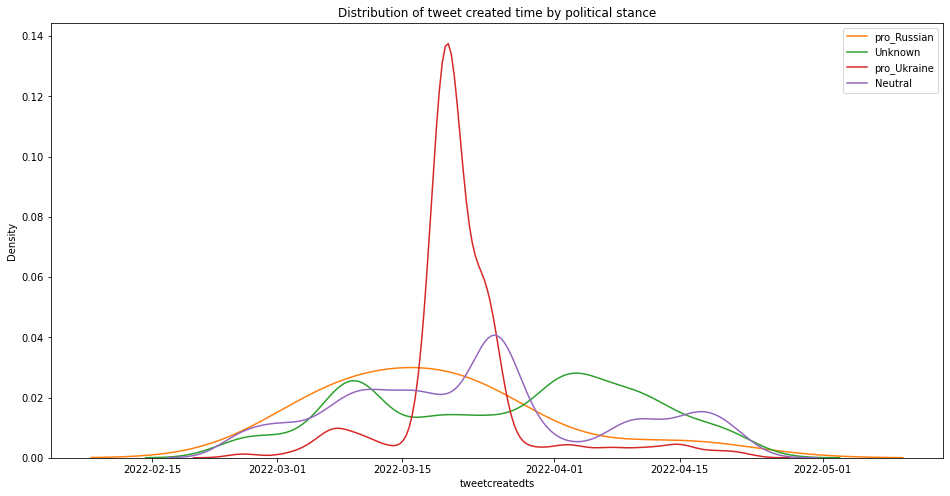

In [7]:
#plot time distribution of tweets
import matplotlib.pyplot as plt
import seaborn as sns

df_smo = pd.read_csv("20220508keywords_smo.csv")

df_smo['usercreatedts'] = pd.to_datetime(df_smo['usercreatedts'], errors='coerce')
df_smo['tweetcreatedts'] = pd.to_datetime(df_smo['tweetcreatedts'], errors='coerce')


# Distribution of tweet created time by political stance
fig, ax = plt.subplots(figsize=(16,8))
for stance in df_smo['NodeType'].value_counts().sort_values().index.tolist():
    sns.kdeplot(df_smo[df_smo['NodeType']==stance]['tweetcreatedts'],ax=ax, label=stance)
ax.legend()
ax.set_title("Distribution of tweet created time by political stance")
plt.show()


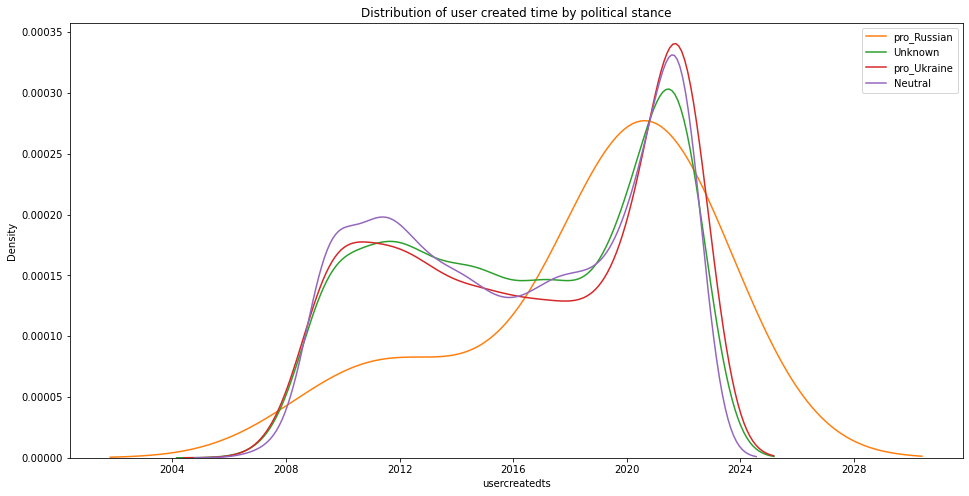

In [8]:
# Distribution of user created time by political stance
fig, ax = plt.subplots(figsize=(16,8))
for stance in df_smo['NodeType'].value_counts().sort_values().index.tolist():
    sns.kdeplot(df_smo[df_smo['NodeType']==stance]['usercreatedts'],ax=ax, label=stance)
ax.legend()
ax.set_title("Distribution of user created time by political stance")
plt.show()

## "Neo-Nazi"

In [10]:
df_nci = pd.read_csv("20220508keywords_nci.csv")

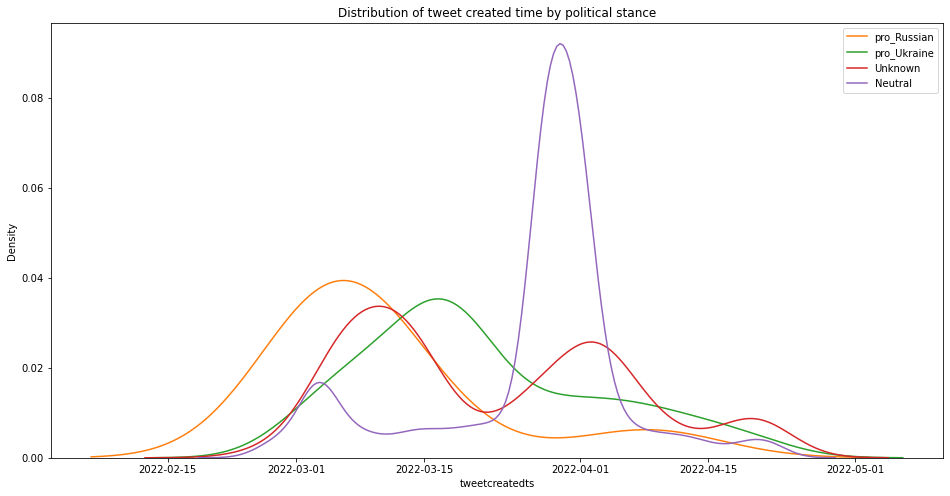

In [11]:
# a function to split and clean "hashtags" column

def SplitTags(hashtags):
    TAGS=[]
    if hashtags != '[]':
        tags_split = hashtags[1:-1].split('{')
        for t in tags_split:
            if t!='':
                TAGS+=[t.split(': ')[1].split(',')[0][1:-1]]
        return TAGS
    else: return "NA"

def LowerTags(hashtags):
    TAGS=[]
    if hashtags != '[]':
        tags_split = hashtags[1:-1].split('{')
        for t in tags_split:
            if t!='':
                TAGS+=[t.split(': ')[1].split(',')[0][1:-1]]
    lower_TAGS = (map(lambda x: x.lower(), TAGS))
    TAGS = list(lower_TAGS)
    if len(TAGS)>0:
        return TAGS
    else: return "NA"

            
df_nci['tags_splitted'] = df_nci['hashtags'].apply(SplitTags)
df_nci['tags_lower'] = df_nci['hashtags'].apply(LowerTags)

# import the manually labelled new hashtag list
with open("labelled.txt", 'r', encoding='UTF-8') as infile:
    lines = infile.readlines()

    labelled_tags = pd.DataFrame(columns=lines[0].split())
    
    for line in lines[1:]:
        df_length = len(labelled_tags)
        labelled_tags.loc[df_length] = line.split()[1:]
        
labelled_tags["pro_u"] = labelled_tags["pro_u"].apply(lambda x: eval(x))
labelled_tags["pro_r"] = labelled_tags["pro_r"].apply(lambda x: eval(x))
labelled_tags["neutral"] = labelled_tags["neutral"].apply(lambda x: eval(x))
labelled_tags.head()

pro_russian_tags = labelled_tags["tag"][labelled_tags["pro_r"]==True]
pro_ukrainian_tags = labelled_tags["tag"][labelled_tags["pro_u"]==True]
neural_tags = labelled_tags["tag"][labelled_tags["neutral"]==True]

# change all tags to lowercase before matching to avoid spelling difference
lower_R = (map(lambda x: x.lower(), pro_russian_tags))
pro_russian_tags = list(lower_R)

lower_U = (map(lambda x: x.lower(), pro_ukrainian_tags))
pro_ukrainian_tags = list(lower_U)

lower_N = (map(lambda x: x.lower(), neural_tags))
neural_tags = list(lower_N)

# Create lambda functions to mark political orientation if related hashtags were found 

# lambda functions marking political orientation if related hashtags were found 
pro_R_check = lambda taglist: bool(set(taglist) & set(pro_russian_tags)) # return true if overlap of two sets not empty
pro_U_check = lambda taglist: bool(set(taglist) & set(pro_ukrainian_tags)) 
N_check = lambda taglist: bool(set(taglist) & set(neural_tags)) 


df_nci['pro_Russian'] = df_nci['tags_lower'].apply(pro_R_check)
df_nci['pro_Ukraine'] = df_nci['tags_lower'].apply(pro_U_check)
df_nci['Neutral'] = df_nci['tags_lower'].apply(N_check)

# Determine a tweet's stance by it's hashtags: pro-russian / pro-ukrainian / both/ Neutral/ unknown
df_nci['NodeType'] = np.where(
     df_nci['pro_Russian'] & df_nci['pro_Ukraine'], 'Both',
     np.where(
         df_nci['pro_Russian'],  'pro_Russian',
     np.where(
        df_nci['pro_Ukraine'], 'pro_Ukraine', 
     np.where(
         df_nci['Neutral'],'Neutral','Unknown'
     ))))

df_nci.head(2)

#plot time distribution of tweets
import matplotlib.pyplot as plt
import seaborn as sns



df_nci['usercreatedts'] = pd.to_datetime(df_nci['usercreatedts'], errors='coerce')
df_nci['tweetcreatedts'] = pd.to_datetime(df_nci['tweetcreatedts'], errors='coerce')


# Distribution of tweet created time by political stance
fig, ax = plt.subplots(figsize=(16,8))
for stance in df_nci['NodeType'].value_counts().sort_values().index.tolist():
    sns.kdeplot(df_nci[df_nci['NodeType']==stance]['tweetcreatedts'],ax=ax, label=stance)
ax.legend()
ax.set_title("Distribution of tweet created time by political stance")
plt.show()



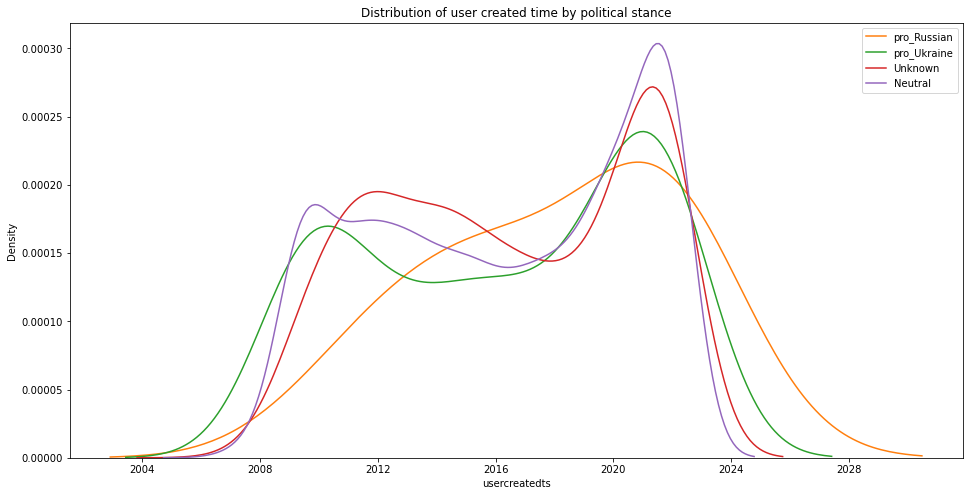

In [12]:
# Distribution of user created time by political stance
fig, ax = plt.subplots(figsize=(16,8))
for stance in df_nci['NodeType'].value_counts().sort_values().index.tolist():
    sns.kdeplot(df_nci[df_nci['NodeType']==stance]['usercreatedts'],ax=ax, label=stance)
ax.legend()
ax.set_title("Distribution of user created time by political stance")
plt.show()

In [13]:
df_N = df_nci[df_nci['NodeType']=="Neutral"]
df_N = df_N.sort_values(by=['tweetcreatedts'])
# export dataframe 
#df_N.to_csv("neu_nazi_neutral_tweets.csv",sep = ",", header = True, encoding = "UTF-8",index=False)